In [75]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings 
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *
from statsforecast import StatsForecast
from statsforecast.models import (
    Naive,WindowAverage, ARIMA, 
    AutoARIMA,SeasonalNaive,HoltWinters,
    CrostonClassic as Croston, HistoricAverage,DynamicOptimizedTheta as DOT,
    SeasonalNaive
)
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple, Union
from itertools import product


warnings.filterwarnings("ignore")  # To ignore warnings from pandas/numpy

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Color palette for up to 4 models
MODEL_COLORS = {
    0: '#E94F37',  # Red
    1: '#2E86AB',  # Blue
    2: '#28A745',  # Green
    3: '#9B59B6',  # Purple
}
HISTORICAL_COLOR = "#898992" 

In [76]:
user="Lilian"

In [77]:
@dataclass
class ForecastConfig:
    
    # Forecast parameters
    h: int = 8                          
    season_length: int = 4              
    
    # Cross-validation parameters
    n_windows: int = 3                  
    step_size: Optional[int] = None     
    
    # Train-test split parameters
    train_size: Optional[int] = None    # Use all available data except test
    test_size: Optional[int] = None     # Auto-set to h in __post_init__
    
    # Plotting parameters
    n_samples: int = 4                  # Plot 4 random samples
    models_to_plot: Optional[List[str]] = None  # 
    
    # Other settings
    confidence_level: int = 95          # 95% confidence intervals
    n_jobs: int = -1                    
    
    def __post_init__(self):
        
        if self.step_size is None:
            self.step_size = self.h
        if self.test_size is None:
            self.test_size = self.h
        if self.models_to_plot is None:
            self.models_to_plot = ['Naive', 'ARIMA_manual', 'SARIMA']

In [78]:
def get_models(config):
    
    models = [Naive(), HistoricAverage(), WindowAverage(window_size=4),
        SeasonalNaive(season_length=4), ARIMA(order=(1, 1, 1), alias="ARIMA_manual"),
        AutoARIMA(seasonal=True, season_length=4, alias="SARIMA"),
    ]
    return models

def evaluate_train_test(df, target_name, config):

    if config.train_size is None:
        train = df.groupby('unique_id').apply(
            lambda x: x.iloc[:-config.test_size]
        ).reset_index(drop=True)
    else:
        train = df.groupby('unique_id').apply(
            lambda x: x.iloc[-(config.train_size + config.test_size):-config.test_size]
        ).reset_index(drop=True)
    
    test = df.groupby('unique_id').apply(
        lambda x: x.iloc[-config.test_size:]
    ).reset_index(drop=True)
    
    sf = StatsForecast(
        models=get_models(config),
        freq='QS',
        n_jobs=config.n_jobs,
        fallback_model=SeasonalNaive(season_length=config.season_length)
    )
    sf.fit(df=train)
    preds = sf.predict(h=config.h)

    preds_df = pd.merge(test, preds.reset_index(), on=['ds', 'unique_id'], how='left')
    models = [col for col in preds.columns if col not in ['unique_id', 'ds']]
    
    eval_df = evaluate(preds_df, metrics=[mae, mse, rmse], models=models)
    
    mae_df = eval_df[eval_df['metric'] == 'mae'].copy()
    mae_df['best_model'] = mae_df[models].idxmin(axis=1)

    
    print(f"\n📈 Best Models (Train-Test Split - based on MAE):")
    print(mae_df['best_model'].value_counts())
    
    return eval_df, preds_df, train, test 

def evaluate_model_cross(df, target_name, config):
    
    sf = StatsForecast(
        models=get_models(config),
        freq='QS',
        n_jobs=config.n_jobs,
        fallback_model=SeasonalNaive(season_length=config.season_length)
    )

    print(f"   Running cross-validation...")
    cv_df = sf.cross_validation(
        df=df,
        h=config.h,
        n_windows=config.n_windows,
        step_size=config.step_size
    )
    
    # Define model columns
    exclude_cols = ['unique_id', 'ds', 'y', 'cutoff', 'metric']
    model_cols = [col for col in cv_df.columns if col not in exclude_cols]

    # Evaluate per cutoff window
    all_results = []
    
    for cutoff in cv_df['cutoff'].unique():
        cutoff_data = cv_df[cv_df['cutoff'] == cutoff]
        
        # Evaluate all metrics for this cutoff
        cutoff_eval = evaluate(cutoff_data, metrics=[mae, mse, rmse], models=model_cols)
        cutoff_eval['cutoff'] = cutoff
        
        # Add best_model column (lowest value per row, regardless of metric)
        cutoff_eval['best_model'] = cutoff_eval[model_cols].idxmin(axis=1)
        cutoff_eval['best_value'] = cutoff_eval[model_cols].min(axis=1)
        
        all_results.append(cutoff_eval)
        
        # Print MAE summary for this cutoff
        cutoff_mae = cutoff_eval[cutoff_eval['metric'] == 'mae']
        print(f"\n   Cutoff {cutoff.strftime('%Y-%m-%d')} (MAE best models):")
        print(f"   {cutoff_mae['best_model'].value_counts().to_dict()}")

    # Combine all cutoff results into single dataframe
    eval_df = pd.concat(all_results, ignore_index=True)
    
    # Print overall summary
    mae_overall = eval_df[eval_df['metric'] == 'mae']
    print(f"\n📈 Overall Best Models (all cutoffs - based on MAE):")
    print(mae_overall['best_model'].value_counts())
    
    return eval_df, cv_df

def sensitivity_analysis_with_production_forecasts(df, target_name, param_grid=None, production_horizons=[4, 8], save_path=None):
    
    # Default parameter grid if not provided
    if param_grid is None:
        param_grid = {
            'h': [4, 8],
            'test_size': [4, 8],
            'train_size': [None, 20, 28],
            'n_windows': [2, 3, 4],
            'step_size': [None, 2, 4],
        }
   
    print("\nPHASE 1: SENSITIVITY ANALYSIS")
    
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))
    
    print(f"Testing {len(combinations)} configurations...")
    
    all_results = []
    
    for i, combo in enumerate(combinations):
        params = dict(zip(param_names, combo))
        
        # Skip invalid combinations
        if params.get('test_size') and params.get('h'):
            if params['test_size'] < params['h']:
                continue
        
        print(f"\nConfiguration {i+1}/{len(combinations)}: {params}")
        
        try:
            config = ForecastConfig(
                h=params.get('h', 8),
                train_size=params.get('train_size'),
                test_size=params.get('test_size'),
                n_windows=params.get('n_windows', 2),
                step_size=params.get('step_size'),
                season_length=4,
                n_samples=4,
                confidence_level=95,
                n_jobs=-1
            )
            
            # Run train-test evaluation
            eval_traintest, preds_traintest, train_df, test_df = evaluate_train_test(
                df, target_name, config
            )
            
            # Run cross-validation
            eval_cv, cv_df = evaluate_model_cross(df, target_name, config)
            
            # Extract MAE results
            mae_cv = eval_cv[eval_cv['metric'] == 'mae'].copy()
            mae_traintest = eval_traintest[eval_traintest['metric'] == 'mae'].copy()
            
            # Get model columns
            exclude_cols = ['unique_id', 'ds', 'y', 'cutoff', 'metric', 'best_model', 'best_value']
            model_cols = [col for col in mae_cv.columns if col not in exclude_cols]
            
            # Add best_model to train-test if not present
            if 'best_model' not in mae_traintest.columns:
                mae_traintest['best_model'] = mae_traintest[model_cols].idxmin(axis=1)
            
            # Store results
            for uid in df['unique_id'].unique():
                uid_cv = mae_cv[mae_cv['unique_id'] == uid]
                uid_traintest = mae_traintest[mae_traintest['unique_id'] == uid]
                
                cv_best_model = uid_cv['best_model'].mode().iloc[0] if len(uid_cv) > 0 else None
                cv_best_count = (uid_cv['best_model'] == cv_best_model).sum()
                cv_total = len(uid_cv)
                cv_consistency = cv_best_count / cv_total if cv_total > 0 else 0
                
                traintest_best_model = uid_traintest['best_model'].iloc[0] if len(uid_traintest) > 0 else None
                
                result_row = {
                    'unique_id': uid,
                    'config_id': i + 1,
                    **params,
                    'cv_best_model': cv_best_model,
                    'cv_consistency': cv_consistency,
                    'traintest_best_model': traintest_best_model,
                    'cv_traintest_agree': cv_best_model == traintest_best_model,
                }
                
                # Add MAE values for each model
                for model in model_cols:
                    model_mae = uid_cv[model].mean() if len(uid_cv) > 0 else None
                    result_row[f'{model}_mae'] = model_mae
                
                all_results.append(result_row)
            
            print(f"   ✓ Completed successfully")
            
        except Exception as e:
            print(f"   ✗ Error: {str(e)}")
            continue
    
    results_df = pd.DataFrame(all_results)
    
    print("\nPHASE 2: IDENTIFYING BEST MODELS PER HORIZON")
    recommendations_per_horizon = {}
    
    for horizon in production_horizons:
        print(f"\n🎯 Analyzing h={horizon}...")
        
        # Filter results for this horizon
        horizon_results = results_df[results_df['h'] == horizon].copy()
        
        if len(horizon_results) == 0:
            print(f"   ⚠️ No results found for h={horizon}, skipping")
            continue
        
        # Get recommendations for each unique_id at this horizon
        horizon_recommendations = []
        
        for uid in horizon_results['unique_id'].unique():
            uid_data = horizon_results[horizon_results['unique_id'] == uid]
            
            # Most frequent CV best model
            cv_mode = uid_data['cv_best_model'].mode()
            cv_best = cv_mode.iloc[0] if len(cv_mode) > 0 else None
            cv_freq = (uid_data['cv_best_model'] == cv_best).sum() / len(uid_data)
            
            # Most frequent train-test best model
            tt_mode = uid_data['traintest_best_model'].mode()
            tt_best = tt_mode.iloc[0] if len(tt_mode) > 0 else None
            tt_freq = (uid_data['traintest_best_model'] == tt_best).sum() / len(uid_data)
            
            # Average consistency
            avg_consistency = uid_data['cv_consistency'].mean()
            
            # Determine recommendation
            if cv_best == tt_best and cv_freq >= 0.7 and avg_consistency >= 0.7:
                confidence = 'High'
                recommended_model = cv_best
                reason = "CV and Train-Test agree, high frequency and consistency"
            elif cv_best == tt_best and cv_freq >= 0.5:
                confidence = 'Medium-High'
                recommended_model = cv_best
                reason = "CV and Train-Test agree with moderate frequency"
            elif cv_freq >= 0.6:
                confidence = 'Medium'
                recommended_model = cv_best
                reason = f"CV favors {cv_best} ({cv_freq:.0%})"
            elif tt_freq >= 0.6:
                confidence = 'Medium'
                recommended_model = tt_best
                reason = f"Train-Test favors {tt_best} ({tt_freq:.0%})"
            else:
                confidence = 'Low'
                mae_cols = [col for col in uid_data.columns if col.endswith('_mae')]
                if mae_cols:
                    avg_maes = uid_data[mae_cols].mean()
                    min_col= avg_maes.idxmin()
                    if isinstance(min_col, str):
                        recommended_model = min_col.replace('_mae', '')
                    else:
                        recommended_model = cv_best  # fallback if idxmin is not a string
                else:
                    recommended_model = cv_best
                reason = "No clear winner - using lowest average MAE"
            
            # Get average MAE
            rec_mae_col = f'{recommended_model}_mae'
            avg_mae = uid_data[rec_mae_col].mean() if rec_mae_col in uid_data.columns else None
            
            recommendation = {
                'unique_id': uid,
                'horizon': horizon,
                'recommended_model': recommended_model,
                'confidence': confidence,
                'reason': reason,
                'cv_best_model': cv_best,
                'cv_frequency': cv_freq,
                'cv_consistency': avg_consistency,
                'traintest_best_model': tt_best,
                'avg_mae': avg_mae
            }
            
            horizon_recommendations.append(recommendation)
            if avg_mae is not None and pd.notna(avg_mae):
                mae_display = f"{avg_mae:,.0f}"
            else:
                mae_display = "N/A"
        
        recommendations_per_horizon[horizon] = pd.DataFrame(horizon_recommendations)
    

    print("\nPHASE 3: GENERATING PRODUCTION FORECASTS")
    
    production_forecasts = {}
    
    for horizon in production_horizons:
        if horizon not in recommendations_per_horizon:
            continue
            
        print(f"\n🔮 Generating forecasts for h={horizon}...")
        
        recommendations = recommendations_per_horizon[horizon]
        
        # Train on FULL dataset
        config_prod = ForecastConfig(
            h=horizon,
            season_length=4,
            confidence_level=95,
            n_jobs=-1
        )
        
        # Train all models on full data
        sf = StatsForecast(
            models=get_models(config_prod),
            freq='QS',
            n_jobs=-1,
            fallback_model=SeasonalNaive(season_length=4)
        )
        
        forecasts_df = sf.forecast(df=df, h=horizon, level=[95])
        
        # Create a "best model" forecast by selecting the recommended model for each unique_id
        best_forecasts = []
        
        for uid in df['unique_id'].unique():
            uid_forecasts = forecasts_df.reset_index()
            uid_forecasts = uid_forecasts[uid_forecasts['unique_id'] == uid]
            
            uid_rec = recommendations[recommendations['unique_id'] == uid]
            if len(uid_rec) == 0:
                print(f"   ⚠️ No recommendation found for {uid}, skipping")
                continue
            
            best_model = uid_rec['recommended_model'].iloc[0]
            
            for _, row in uid_forecasts.iterrows():
                best_row = {
                    'unique_id': uid,
                    'ds': row['ds'],
                    'recommended_model': best_model,
                    'forecast': row.get(best_model, np.nan),
                    'forecast_lo_95': row.get(f'{best_model}-lo-95', np.nan),
                    'forecast_hi_95': row.get(f'{best_model}-hi-95', np.nan)
                }
                best_forecasts.append(best_row)
        
        best_forecasts_df = pd.DataFrame(best_forecasts)
        
        production_forecasts[horizon] = {
            'all_models': forecasts_df,
            'best_model': best_forecasts_df,
            'recommendations': recommendations
        }
        
        print(f"   ✓ Generated {len(best_forecasts_df)} forecast periods")
        print(f"   ✓ Models used: {recommendations['recommended_model'].value_counts().to_dict()}")
    
        print("\nPHASE 4: SAVING RESULTS")
        
        if save_path:
            os.makedirs(save_path, exist_ok=True)
            rec_frames=list(recommendations_per_horizon.values())
            all_recs = pd.concat(rec_frames, ignore_index=True) if rec_frames else pd.DataFrame()
            # Save sensitivity analysis results
            sensitivity_file = os.path.join(save_path, f'{target_name.lower().replace(" ", "_")}_sensitivity_analysis.xlsx')
            with pd.ExcelWriter(sensitivity_file, engine='openpyxl') as writer:
                results_df.to_excel(writer, sheet_name='All_Configurations', index=False)
                all_recs.to_excel(writer, sheet_name='Recommendations', index=False)
            
            print(f"✓ Sensitivity analysis saved: {sensitivity_file}")
            
            # Save production forecasts for each horizon
            for horizon, forecasts in production_forecasts.items():
                horizon_file = os.path.join(save_path, f'{target_name.lower().replace(" ", "_")}_production_h{horizon}.xlsx')
                with pd.ExcelWriter(horizon_file, engine='openpyxl') as writer:
                    forecasts['all_models'].reset_index().to_excel(writer, sheet_name='All_Models', index=False)
                    forecasts['best_model'].to_excel(writer, sheet_name='Best_Model_Forecast', index=False)
                    forecasts['recommendations'].to_excel(writer, sheet_name='Model_Selection', index=False)
                print(f"✓ Production forecasts (h={horizon}) saved: {horizon_file}")
        else:
            print("   ⚠️ No save_path provided - skipping file export")
                
        
    return {
        'sensitivity_results': results_df,
        'production_forecasts': production_forecasts,
        'recommendations_per_horizon': recommendations_per_horizon
    }

In [79]:
def load_data(filepath, states=None):
    
    df=pd.read_csv(filepath)
    #Filtering for certain years
    df = df[(df['Period'] >= '2017Q1') & (df['Period'] <= '2024Q4')].copy()
    if states is not None:
        if isinstance(states, str):
            states = [states]
        print(f"Filtering data for states: {states}")
        df = df[df['State'].isin(states)].copy()
        print(f"Filtered to {len(df)} rows across {df['State'].unique()} state(s)")
        if len(df) == 0:
            raise ValueError("No data available after filtering by states.")    
    
    df['unique_id']=df['State']
    df['ds']=pd.to_datetime(df['Period'])
    df=df.sort_values(['unique_id','ds']).reset_index(drop=True)
    df_pop=df[['unique_id','ds','Population']].copy()
    df_pop.columns = ['unique_id', 'ds', 'y']
    

    return df_pop,df


In [80]:
pop_csv_path=rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\merged_data\Prebuilt_panels\medi_pop.csv"
pop_save_path=rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\Forecast\Pop\\"

In [81]:
def plot_population_forecast_single_state(
    df_historical: pd.DataFrame,
    df_forecast: pd.DataFrame,
    state: str,
    model_cols: List[str] = ['Naive', 'SARIMA'],
    show_ci: bool = True,
    figsize: Tuple[int, int] = (14, 7),
    title: Optional[str] = None,
    save_path: Optional[str] = None
) -> plt.Figure:

    if len(model_cols) > 4:
        print(f"Warning: Only first 4 models plotted.")
        model_cols = model_cols[:4]
    
    df_hist = df_historical.copy()
    df_fore = df_forecast.copy()
    if 'ds' not in df_fore.columns and 'ds' in df_fore.index.names:
        df_fore = df_fore.reset_index()
    df_hist['ds'] = pd.to_datetime(df_hist['ds'])
    df_fore['ds'] = pd.to_datetime(df_fore['ds'])
    
    hist_state = df_hist[df_hist['unique_id'] == state].sort_values('ds')
    fore_state = df_fore[df_fore['unique_id'] == state].sort_values('ds')
    
    if len(hist_state) == 0:
        print(f"No data for state: {state}")
        return None
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Historical
    ax.plot(hist_state['ds'], hist_state['y'] / 1e6, color=HISTORICAL_COLOR,
            linewidth=2.5, marker='o', markersize=5, label='Historical', zorder=10)
    
    last_hist = hist_state.iloc[-1]
    
    # Each model
    for idx, model_col in enumerate(model_cols):
        if model_col not in fore_state.columns:
            print(f"Warning: '{model_col}' not found. Skipping.")
            continue
        color = MODEL_COLORS[idx]
        # Connect
        ax.plot([last_hist['ds'], fore_state['ds'].iloc[0]],
                [last_hist['y'] / 1e6, fore_state[model_col].iloc[0] / 1e6],
                color=color, linewidth=2, linestyle='--', alpha=0.7)
        # Forecast
        ax.plot(fore_state['ds'], fore_state[model_col] / 1e6, color=color,
                linewidth=2, marker='s', markersize=6, linestyle='--', label=f'{model_col}')
        # CI
        lo_col, hi_col = f'{model_col}-lo-95', f'{model_col}-hi-95'
        if show_ci and lo_col in fore_state.columns and hi_col in fore_state.columns:
            ax.fill_between(fore_state['ds'], fore_state[lo_col]/1e6, fore_state[hi_col]/1e6,
                           color=color, alpha=0.15, label=f'{model_col} 95% CI')
    
    ax.axvline(x=last_hist['ds'], color='gray', linestyle=':', alpha=0.7, linewidth=2, label='Forecast Start')
    ax.set_xlabel('Year-Quarter', fontsize=12)
    ax.set_ylabel('Population (Millions)', fontsize=12)
    ax.set_title(title or f'{state} - Medicaid Population Forecast Comparison', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10, ncol=2)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✔ Saved: {save_path}")
    plt.show()
    return fig


def plot_population_forecast_all_states(
    df_historical: pd.DataFrame,
    df_forecast: pd.DataFrame,
    states: List[str],
    model_cols: List[str] = ['Naive', 'SARIMA'],
    show_ci: bool = True,
    figsize_per_state: Tuple[int, int] = (14, 6),
    save_dir: Optional[str] = None
) -> Dict[str, plt.Figure]:
    
    figures = {}
    for state in states:
        print(f"\n📊 Plotting {state}...")
        save_path = os.path.join(save_dir, f'{state}_population_forecast.png') if save_dir else None
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
        fig = plot_population_forecast_single_state(
            df_historical=df_historical, df_forecast=df_forecast, state=state,
            model_cols=model_cols, show_ci=show_ci, figsize=figsize_per_state, save_path=save_path)
        if fig:
            figures[state] = fig
    print(f"\n✅ Generated {len(figures)} state plots")
    return figures

In [82]:
df_pop, df_original = load_data(filepath=pop_csv_path, states=['IN'])
# 'IN','MI','OH','IL'
config = ForecastConfig()

# This is the manual way using config if you want to run individual evaluations
print("\n1. Train-Test Evaluation...")
eval_traintest, preds_traintest, train, test = evaluate_train_test(
    df_pop, "Population", config
)

print("\n2. Cross-Validation...")
eval_cv, cv_df = evaluate_model_cross(
    df_pop, "Population", config
)

print("\n3. Generate Forecasts...")
sf = StatsForecast(
    models=get_models(config),
    freq='QS',
    n_jobs=config.n_jobs,
    fallback_model=SeasonalNaive(season_length=config.season_length)
)
forecasts = sf.forecast(df=df_pop, h=config.h, level=[config.confidence_level])

# Save
forecasts.reset_index().to_csv(
    os.path.join(pop_save_path, f'population_forecast_h{config.h}.csv'),
    index=False
)

Filtering data for states: ['IN']
Filtered to 32 rows across ['IN'] state(s)

1. Train-Test Evaluation...

📈 Best Models (Train-Test Split - based on MAE):
best_model
WindowAverage    1
Name: count, dtype: int64

2. Cross-Validation...
   Running cross-validation...

   Cutoff 2018-10-01 (MAE best models):
   {'HistoricAverage': 1}

   Cutoff 2020-10-01 (MAE best models):
   {'ARIMA_manual': 1}

   Cutoff 2022-10-01 (MAE best models):
   {'WindowAverage': 1}

📈 Overall Best Models (all cutoffs - based on MAE):
best_model
HistoricAverage    1
ARIMA_manual       1
WindowAverage      1
Name: count, dtype: int64

3. Generate Forecasts...


In [87]:

#Sensitivity analysis with production forecasts
df_pop, df_original = load_data(filepath=pop_csv_path, states=['MI'])
param_grid = {
    'h': [4, 8],
    'test_size': [4, 8],
    'train_size': [26,None],
    'n_windows': [2,3],
    'step_size': [4],
}

results = sensitivity_analysis_with_production_forecasts(
    df=df_pop,
    target_name="Population",
    param_grid=param_grid,
    production_horizons=[4, 8],
    save_path=pop_save_path
)

Filtering data for states: ['MI']
Filtered to 32 rows across ['MI'] state(s)

PHASE 1: SENSITIVITY ANALYSIS
Testing 16 configurations...

Configuration 1/16: {'h': 4, 'test_size': 4, 'train_size': 26, 'n_windows': 2, 'step_size': 4}

📈 Best Models (Train-Test Split - based on MAE):
best_model
HistoricAverage    1
Name: count, dtype: int64
   Running cross-validation...

   Cutoff 2022-10-01 (MAE best models):
   {'Naive': 1}

   Cutoff 2023-10-01 (MAE best models):
   {'HistoricAverage': 1}

📈 Overall Best Models (all cutoffs - based on MAE):
best_model
Naive              1
HistoricAverage    1
Name: count, dtype: int64
   ✓ Completed successfully

Configuration 2/16: {'h': 4, 'test_size': 4, 'train_size': 26, 'n_windows': 3, 'step_size': 4}

📈 Best Models (Train-Test Split - based on MAE):
best_model
HistoricAverage    1
Name: count, dtype: int64
   Running cross-validation...

   Cutoff 2021-10-01 (MAE best models):
   {'SARIMA': 1}

   Cutoff 2022-10-01 (MAE best models):
   {'Naive


PLOTTING POPULATION FORECASTS

📊 Plotting IN...


✔ Saved: C:\Users\Lilian\OneDrive - purdue.edu\VS code\Data\ATC\Forecast\Pop\\IN_population_forecast.png


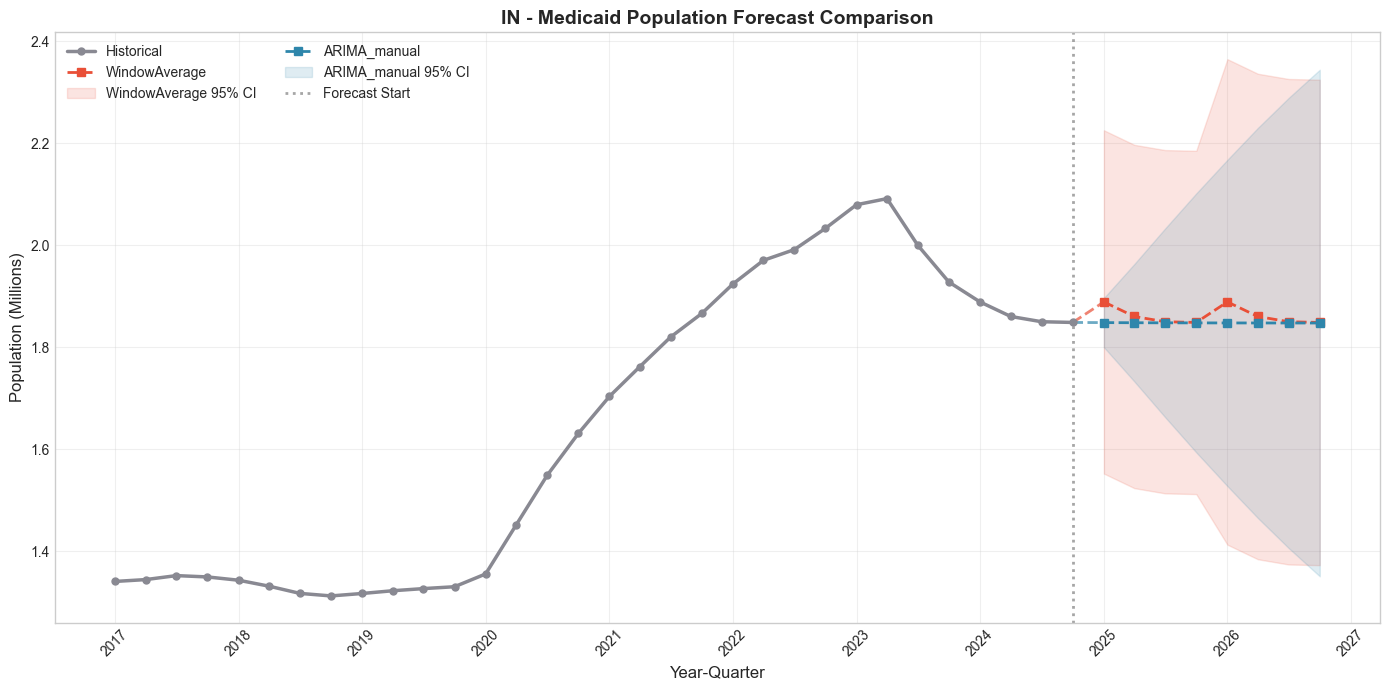


✅ Generated 1 state plots


In [84]:
print("\n" + "="*70)
print("PLOTTING POPULATION FORECASTS")
print("="*70)

# Models to compare (max 4)
models_to_compare = ['WindowAverage', 'ARIMA_manual']

# Plot each state SEPARATELY
state_figures = plot_population_forecast_all_states(
    df_historical=df_pop,      # Historical data
    df_forecast=forecasts,     # Forecast data
    states=['IN'],
    model_cols=models_to_compare,
    show_ci=True,
    figsize_per_state=(14, 7),
    save_dir=pop_save_path
)